In [1]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

# spacy for lemmatization
import spacy
from spacy.tokenizer import Tokenizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [9]:
file_path = './data/'
file_name_review = 'yelp_review.csv'
file_name_business = 'yelp_business.csv'

In [11]:
df_business = pd.read_csv(file_path + file_name_business, nrows=30)
df_business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [21]:
cols = ['business_id', 'name', 'categories']
df_business = pd.read_csv(file_path + file_name_business, usecols = cols) 
print("Total Rows:", df_business.shape[0], ", Total Columns:", df_business.shape[1], ", Total Memory Usage (Bytes):",df_business.memory_usage().sum())

df_business = df_business[df_business['categories'].str.contains('Restaurants')]
print("After selecting only Restaurants ")
print("Total Rows:", df_business.shape[0], ", Total Columns:", df_business.shape[1], ", Total Memory Usage (Bytes):",df_business.memory_usage().sum())

df_business.head()

Total Rows: 174567 , Total Columns: 3 , Total Memory Usage (Bytes): 4189736
After selecting only Restaurants 
Total Rows: 54618 , Total Columns: 3 , Total Memory Usage (Bytes): 1747776


,business_id,name,categories
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",American (New);Nightlife;Bars;Sandwiches;Ameri...
5,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",Italian;Restaurants
10,XOSRcvtaKc_Q5H1SAzN20A,"""East Coast Coffee""",Breakfast & Brunch;Gluten-Free;Coffee & Tea;Fo...
14,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""",Restaurants;American (Traditional)
15,l09JfMeQ6ynYs5MCJtrcmQ,"""Alize Catering""",Italian;French;Restaurants


In [22]:
df_reviews = pd.read_csv(file_path + file_name_review, nrows=30)
df_reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [24]:
cols = ['review_id', 'business_id', 'date', 'stars', 'text']
df_reviews = pd.read_csv(file_path + file_name_review, usecols = cols) 
print("Total Rows:", df_reviews.shape[0], ", Total Columns:", df_reviews.shape[1], \
      ", Total Memory Usage (Bytes):",df_reviews.memory_usage().sum())

df_reviews.head()

Total Rows: 5261668 , Total Columns: 5 , Total Memory Usage (Bytes): 210466848


,review_id,business_id,stars,date,text
0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...
1,n6QzIUObkYshz4dz2QRJTw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...
2,MV3CcKScW05u5LVfF6ok0g,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...
3,IXvOzsEMYtiJI0CARmj77Q,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...
4,L_9BTb55X0GDtThi6GlZ6w,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...


In [25]:
df = pd.merge(df_business, df_reviews, how='inner', on='business_id')

In [28]:
print("Total Rows:", df.shape[0], ", Total Columns:", df.shape[1], \
      ", Total Memory Usage (Bytes):",df.memory_usage().sum())

Total Rows: 3221418 , Total Columns: 7 , Total Memory Usage (Bytes): 206170752


In [29]:
df.head()

,business_id,name,categories,review_id,stars,date,text
0,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",American (New);Nightlife;Bars;Sandwiches;Ameri...,rnvu74aNIPn93Z9Ue11Epw,4,2016-05-05,I've always enjoyed my time at brick house foo...
1,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",American (New);Nightlife;Bars;Sandwiches;Ameri...,OE5dH664oSSK_-TvIl263w,2,2017-03-19,1st time here. Came w my Unc bc Louies was clo...
2,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",American (New);Nightlife;Bars;Sandwiches;Ameri...,SWeHmo8uHHWbbv94VdAMeQ,1,2015-08-31,Worse service ever andI use to be a server so ...
3,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",American (New);Nightlife;Bars;Sandwiches;Ameri...,fCCL0pAgYGccUs8shHHIUA,5,2015-10-09,I am updating my review to 5-stars because I t...
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",American (New);Nightlife;Bars;Sandwiches;Ameri...,-VOh0NNnIo1r24hjwSZL4Q,4,2015-01-15,I enjoyed this place. I went the night the Bu...


In [30]:
df_business, df_reviews = None, None  # RAM usage considerations

In [33]:
df['text'].str.len().min(), df['text'].str.len().max(), df['text'].str.len().mean()

(1, 5052, 596.7661020705789)

In [42]:
df['text_len'] = df['text'].str.len() 

In [44]:
df['text_len'].describe()

count    3.221418e+06
mean     5.967661e+02
std      5.562692e+02
min      1.000000e+00
25%      2.320000e+02
50%      4.210000e+02
75%      7.670000e+02
max      5.052000e+03
Name: text_len, dtype: float64

(array([1873033.,  842822.,  298666.,  115460.,   47222.,   21563.,
          10507.,    5253.,    3115.,    3777.]),
 array([1.0000e+00, 5.0610e+02, 1.0112e+03, 1.5163e+03, 2.0214e+03,
        2.5265e+03, 3.0316e+03, 3.5367e+03, 4.0418e+03, 4.5469e+03,
        5.0520e+03]),
 <a list of 10 Patch objects>)

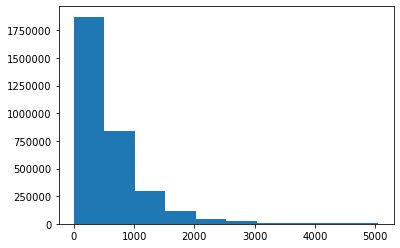

In [47]:
plt.hist(df['text_len'])

(array([379530., 766089., 567807., 394926., 283099., 208404., 151032.,
        112744.,  83041.,  62087.]),
 array([   3. ,  152.7,  302.4,  452.1,  601.8,  751.5,  901.2, 1050.9,
        1200.6, 1350.3, 1500. ]),
 <a list of 10 Patch objects>)

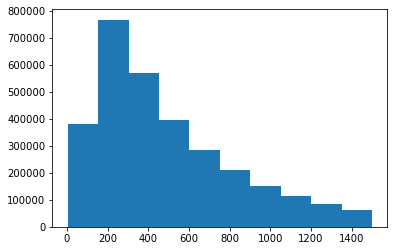

In [54]:
plt.hist(df.loc[(df['text_len'] <= 1500) & (df['text_len'] >= 3),'text_len'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1978e2808d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1978e280438>,
 'boxes': [<matplotlib.lines.Line2D at 0x1978e2e2588>],
 'medians': [<matplotlib.lines.Line2D at 0x1978c86e4e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1978c80afd0>],
 'means': []}

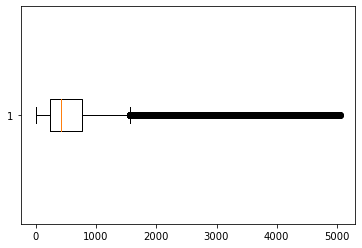

In [46]:
plt.boxplot(df['text_len'], vert=False)

In [48]:
df.loc[df['text_len'] >= 1500, 'text']

3          I am updating my review to 5-stars because I t...
30         Myself, sister and her boyfriend came here for...
31         Been here a few times before. Never been bad.....
55         (Ladies, FYI: I know this is more of a "man's ...
56         I love this place!  The food, the friendly sta...
                                 ...                        
3221172    I have been to Floridino's many times and have...
3221183    After reading the reviews on Yelp, I decided t...
3221297    Q: How did the hipster burn his mouth?\nA: He ...
3221334    After reading multiple Yelp reviews on this bu...
3221358    I've been coming to Floridino's for many years...
Name: text, Length: 213005, dtype: object

In [56]:
pd.to_datetime(df['date']).dt.year.unique()

array([2016, 2017, 2015, 2014, 2012, 2011, 2013, 2005, 2010, 2009, 2008,
       2007, 2006, 2004], dtype=int64)